## Analysis of Loan duration and late returns
This notebook is used to explore possible correlations between loan duration and late returns.

Initialization - read all borrowings from "borrowings" csv-file

In [1]:
import pandas as pd
from pathlib import Path
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import numpy as np
import plotly.express as px

input_file = Path('../dat/processed/borrowings_2019_2025_cleaned.csv')

data_frame = pd.read_csv(
    input_file,
    sep=';',
    quotechar='"',
    encoding='utf-8'
)

print(data_frame.shape)
data_frame.head()

(2357146, 18)


,issue_id,Ausleihdatum/Uhrzeit,Rückgabedatum/Uhrzeit,Leihdauer,Anzahl_Verlängerungen,Verspätet,Tage_zu_spät,Sammlungszeichen/CCODE,Medientyp,Barcode,Titel,Autor,ISBN,Interessenkreis,Benutzerkategorie,Benutzer-Systemnummer,source_year,late_bool
0,56563,2019-01-02 00:00:00,2019-01-24 13:23:23,22.0,0,Nein,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,MDA,26.0,2019,False
1,56564,2019-01-02 00:00:00,2019-01-30 13:40:14,28.0,0,Nein,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,MPA,50.0,2019,False
2,56565,2019-01-02 00:00:00,2019-03-06 07:09:36,63.0,1,Nein,0.0,esac,Sachbuch,18143906,Hamburg - Der besondere Stadtführer,NaN,9783831904525,NaN,MPA,50.0,2019,False
3,56566,2019-01-02 00:00:00,2019-03-06 07:09:38,63.0,1,Nein,0.0,esac,Sachbuch,18184110,Hamburg <Dorling Kindersley>,"Bruschke, Gerhard",9783734205736,NaN,MPA,50.0,2019,False
4,56567,2019-01-02 00:00:00,2019-03-06 07:09:31,63.0,1,Nein,0.0,esac,Sachbuch,17202121,Hamburg <Reise-Know-How>,"Fründt, Hans-Jürgen",9783831730735,NaN,MPA,50.0,2019,False


## Overview
show the amount of borrowings per category

In [2]:
data_frame["Medientyp"].unique()
data_frame["Medientyp"].value_counts()

Medientyp
Kinder u. Jugendbuch           644046
Sachbuch                       321920
DVD                            245197
Belletristik                   232567
Kinder u. Jugend-CD            164620
Comic                          121663
Hörbuch                         55995
Musik-CD                        53266
Fremdsprachige Belletristik     24212
Tonie                           18448
Spiele                          18057
Zeitschriften                   12151
Konsolenspiel                    7115
Sprachkurse                      6501
Sonstiges                        6392
Blu-Ray                          2901
Kamishibai                       1565
Bibliothek der Dinge             1104
Lesehaus                          694
Makerboxen                        606
Bestellt über Medienwelten        542
CD-ROM                            410
Schlüssel                         254
Sach-CD                           101
Tablet                              9
Name: count, dtype: int64

In [3]:
book_categories = [
    "Sachbuch",
    "Belletristik",
    "Fremdsprachige Belletristik",
    "Kinder u. Jugendbuch",
    "Comic"
    "Zeitschriften"
]

books_frame = data_frame[
    data_frame["Medientyp"].isin(book_categories)
].reset_index(drop=True)

non_books_frame = data_frame[
    ~data_frame["Medientyp"].isin(book_categories)
].reset_index(drop=True)

all_data_frame = data_frame

print(f'=== Book Table ===')
print(books_frame.shape)
# display(books_frame.head())

print(f'=== Non Book Table ===')
print(non_books_frame.shape)
# display(non_books_frame.head())

=== Book Table ===
(1222745, 18)
=== Non Book Table ===
(1134401, 18)


## First look at Media Types in combination with late returns
Now we want to examine correlations between media types and borrowings that were returned late. As a first step, we analyze the percentage of items that were returned late. Rows without a media type are ignored.

In [4]:
# remove rows without media type
books_frame = books_frame.dropna(subset=["Medientyp"])
non_books_frame = non_books_frame.dropna(subset=["Medientyp"])
all_data_frame = all_data_frame.dropna(subset=["Medientyp"])

def getLateBorrowingsTable(input_data_frame):
    late_borrowings_per_type = []
    for media_type, media_type_group in input_data_frame.groupby("Medientyp"):
        amount_of_total_entries = len(media_type_group)
        amount_of_late_entries = (media_type_group["Verspätet"] == "Ja").sum()
        percent_late = amount_of_late_entries / amount_of_total_entries * 100

        late_borrowings_per_type.append({
         "Medientyp": media_type,
         "Anzahl_Ausleihen": amount_of_total_entries,
         "Anzahl_verspaetet": amount_of_late_entries,
         "Prozent_verspaetet": percent_late
        })

    late_borrowings_per_type_table = (
        pd.DataFrame(late_borrowings_per_type)
        .sort_values("Prozent_verspaetet", ascending=False)
        .reset_index(drop=True)
    )
    return late_borrowings_per_type_table

late_books_table = getLateBorrowingsTable(books_frame)
late_non_books_table = getLateBorrowingsTable(non_books_frame)

display(late_books_table)
display(late_non_books_table)

,Medientyp,Anzahl_Ausleihen,Anzahl_verspaetet,Prozent_verspaetet
0,Sachbuch,321920,18077,5.615370
1,Fremdsprachige Belletristik,24212,1162,4.799273
2,Kinder u. Jugendbuch,644046,30749,4.774348
3,Belletristik,232567,6293,2.705887


,Medientyp,Anzahl_Ausleihen,Anzahl_verspaetet,Prozent_verspaetet
0,Bibliothek der Dinge,1104,132,11.956522
1,Schlüssel,254,30,11.811024
2,Tablet,9,1,11.111111
3,Makerboxen,606,56,9.240924
4,Sprachkurse,6501,514,7.906476
5,Konsolenspiel,7115,499,7.013352
6,Blu-Ray,2901,180,6.204757
7,Kamishibai,1565,96,6.134185
8,Sonstiges,6392,388,6.070088
9,DVD,245197,14423,5.882209


## Cleanup
For the further analysis, uninteresting media types and media types with fewer than 1,000 entries are removed. This criteria can be adjusted here.

In [5]:
UNINTERESTING_TYPES = [
    "Sonstiges",
    "Lesehaus",
    "Bestellt über Medienwelten",
]
MIN_BORROWINGS = 1000


amount_of_entries_per_type = all_data_frame["Medientyp"].value_counts()
list_of_valid_types = amount_of_entries_per_type[amount_of_entries_per_type >= MIN_BORROWINGS].index
list_of_interesting_types = list_of_valid_types.difference(UNINTERESTING_TYPES)

all_data_frame = all_data_frame[all_data_frame["Medientyp"].isin(list_of_interesting_types)]
books_frame = books_frame[books_frame["Medientyp"].isin(list_of_interesting_types)]
non_books_frame = non_books_frame[non_books_frame["Medientyp"].isin(list_of_interesting_types)]


## Identifying Indicators for Late Returns

The next step is to find good indicators for late returns by analyzing loan duration characteristics and their relationship to overdue behavior across different media types. The table below summarizes key statistics per media type. (boxplots for visualization)

### Column Descriptions

- **mean**: Average loan duration (in days).
- **median**: Median loan duration
- **p75 / p90 / p95**: Upper quantiles of the loan duration distribution, describing long borrowing periods.
- **late_rate_percent**:  Share of borrowings returned late.
- **median_late**: Median loan duration for borrowings that were returned late. Indicates how long overdue items are typically kept.
- **median_on_time**: Median loan duration for borrowings returned on time. Baseline for regular borrowing behavior.
- **Delta_Median**: Difference between late and on-time median loan duration. Highlights whether longer borrowing durations are associated with late returns.


<Figure size 1000x600 with 0 Axes>

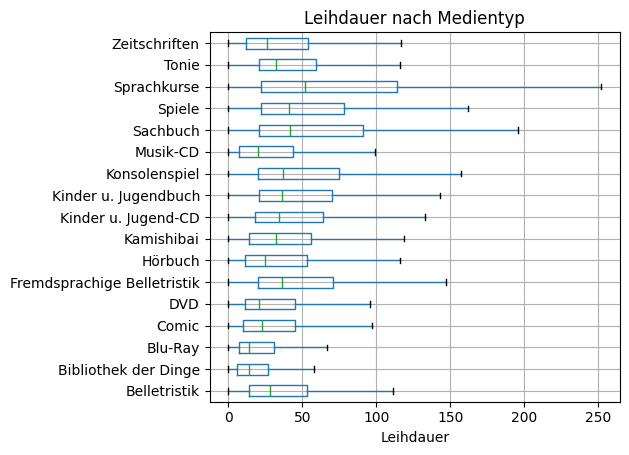

,Medientyp,mean,median,p75,p90,p95,late_rate_percent,median_late,median_on_time,delta_median
14,Sprachkurse,77.129980,52.0,114.0,187.0,225.0,7.906476,117.5,49.0,68.5
16,Zeitschriften,42.847585,26.0,54.0,107.0,159.5,3.637561,92.0,25.0,67.0
11,Musik-CD,37.549319,20.0,44.0,98.0,152.0,1.852964,84.0,19.0,65.0
12,Sachbuch,66.254476,42.0,91.0,166.0,202.0,5.615370,95.0,41.0,54.0
6,Hörbuch,41.642182,25.0,53.0,103.0,147.0,2.425217,68.0,24.0,44.0
5,Fremdsprachige Belletristik,55.313935,36.0,71.0,128.9,174.0,4.799273,78.0,35.0,43.0
3,Comic,35.790109,23.0,45.0,83.0,120.0,3.125026,55.0,22.0,33.0
8,Kinder u. Jugend-CD,50.914634,34.0,64.0,115.0,161.0,3.274815,66.0,33.0,33.0
10,Konsolenspiel,57.408292,37.0,75.0,144.0,184.0,7.013352,66.0,35.0,31.0
13,Spiele,59.353270,41.0,78.0,139.0,182.0,5.654317,69.0,39.0,30.0


In [6]:
leihdauer_stats = (
    all_data_frame
    .groupby("Medientyp")["Leihdauer"]
    .agg(
        mean="mean",
        median="median",
        p75=lambda x: x.quantile(0.75),
        p90=lambda x: x.quantile(0.90),
        p95=lambda x: x.quantile(0.95),
    )
    .reset_index()
)

late_rate = (
    all_data_frame
    .groupby("Medientyp")["Verspätet"]
    .apply(lambda x: (x == "Ja").mean() * 100)
    .rename("late_rate_percent")
)

leihdauer_by_late = (
    all_data_frame
    .groupby(["Medientyp", "Verspätet"])["Leihdauer"]
    .median()
    .unstack()
    .rename(columns={"Ja": "median_late", "Nein": "median_on_time"})
)

leihdauer_by_late["delta_median"] = (
        leihdauer_by_late["median_late"]
        - leihdauer_by_late["median_on_time"]
)

final_table = (
    leihdauer_stats
    .set_index("Medientyp")
    .join(late_rate)
    .join(leihdauer_by_late)
    .reset_index()
    .sort_values("delta_median", ascending=False)
)

order = final_table["Medientyp"].tolist()

plt.figure(figsize=(10, 6))
all_data_frame.boxplot(
    column="Leihdauer",
    by="Medientyp",
    vert=False,
    grid=True,
    showfliers=False
)
plt.suptitle("")
plt.title("Leihdauer nach Medientyp")
plt.xlabel("Leihdauer")
plt.ylabel("")
plt.tight_layout()
plt.show()

display(final_table)


## Takeaways
- across all media categories, late returns are associated with longer loan durations
- in some categories extended usage periods can be considered as a relevant risk signal for late returns (categories with high "delta_median")
- in categories with low "Delta_Median", this relationship is much less pronounced, suggesting that late returns there are driven by different underlying factors.

So there is a correlation between loan duration and late returns. In some categories its more pronounced.
To show this correlation we can look at the following plot (over all categories)

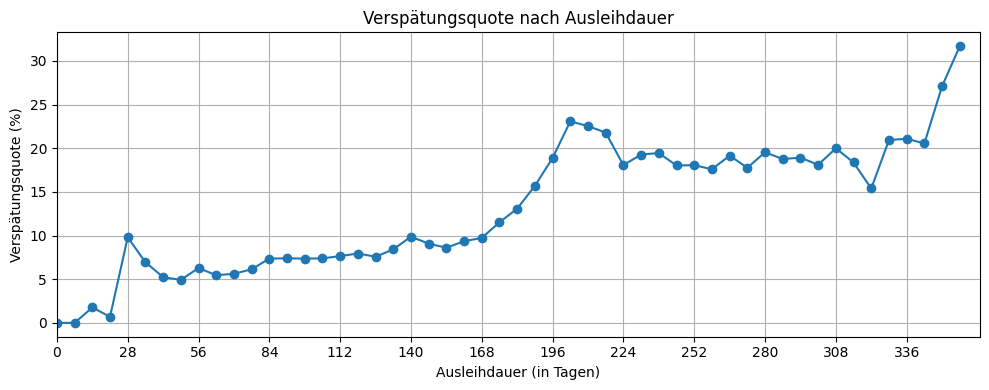

In [7]:
all_data_copy = all_data_frame.copy()

all_data_copy["late"] = (all_data_copy["Verspätet"] == "Ja").astype(int)

# bins of 7 days (for loan duration)
all_data_copy["duration_bin_7d"] = pd.cut(
    all_data_copy["Leihdauer"],
    bins=range(0, 366, 7),
    include_lowest=True
)

# Verspätungsquote pro Bin
late_rate_7d = (
    all_data_copy.groupby("duration_bin_7d", observed=False)["late"]
    .mean()
    * 100
)

# Plot
x_vals = [interval.left for interval in late_rate_7d.index]
plt.figure(figsize=(10, 4))
plt.plot(x_vals, late_rate_7d.values, marker="o")

plt.xlabel("Ausleihdauer (in Tagen)")
plt.ylabel("Verspätungsquote (%)")
plt.title("Verspätungsquote nach Ausleihdauer")

plt.xticks(np.arange(0, max(x_vals) + 1, 28))
plt.xlim(0, 365)

plt.grid(True)
plt.tight_layout()
plt.show()


We can see that a longer loan duration leads to a higher delay rate. In some media types, this correlation is more pronounced (as shown in the table)

## Analysis of extensions and late returns
Another interesting data point are the amount of the extensions. Is there a correlation to late returns?
First we look at the basic properties.

In [8]:
base_table = (
    all_data_frame
    .assign(
        late = all_data_frame["Verspätet"] == "Ja",
        has_extension = all_data_frame["Anzahl_Verlängerungen"] > 0
    )
)

per_media_type_table = (
    base_table
    .groupby("Medientyp")
    .agg(
        n_loans=("Leihdauer", "size"),
        mean_extensions=("Anzahl_Verlängerungen", "mean"),
        median_extensions=("Anzahl_Verlängerungen", "median"),
        max_extensions=("Anzahl_Verlängerungen", "max"),
        pct_with_extension=("has_extension", "mean"),
        late_rate=("late", "mean"),
    )
    .reset_index()
    .assign(
        pct_with_extension=lambda df: (df["pct_with_extension"] * 100).round(2),
        late_rate=lambda df: (df["late_rate"] * 100).round(2),
    )
    .sort_values("late_rate", ascending=False)
)

overall_row = pd.DataFrame([{
    "": "Gesamt",
    "n_loans": base_table["Leihdauer"].size,
    "mean_extensions": base_table["Anzahl_Verlängerungen"].mean(),
    "median_extensions": base_table["Anzahl_Verlängerungen"].median(),
    "max_extensions": base_table["Anzahl_Verlängerungen"].max(),
    "pct_with_extension": base_table["has_extension"].mean(),
    "late_rate": base_table["late"].mean(),
}])

display(per_media_type_table)
display(
    overall_row
    .assign(
        pct_with_extension=lambda df: (df["pct_with_extension"] * 100).round(2),
        late_rate=lambda df: (df["late_rate"] * 100).round(2),
    )
    .style.set_properties(**{"font-weight": "bold" })
)


,Medientyp,n_loans,mean_extensions,median_extensions,max_extensions,pct_with_extension,late_rate
1,Bibliothek der Dinge,1104,0.935688,0.0,7,35.69,11.96
14,Sprachkurse,6501,2.045531,1.0,9,62.88,7.91
10,Konsolenspiel,7115,1.440759,1.0,9,54.18,7.01
2,Blu-Ray,2901,1.378835,1.0,9,51.74,6.20
7,Kamishibai,1565,1.069649,0.0,11,49.46,6.13
4,DVD,245197,1.515777,1.0,18,55.93,5.88
13,Spiele,18057,1.490668,1.0,10,58.32,5.65
12,Sachbuch,321920,1.773857,1.0,13,61.51,5.62
15,Tonie,18448,1.189289,1.0,10,53.07,5.00
5,Fremdsprachige Belletristik,24212,1.411118,1.0,10,57.37,4.80


,,n_loans,mean_extensions,median_extensions,max_extensions,pct_with_extension,late_rate
0,Gesamt,1931328,1.323394,1.000000,18,53.850000,4.460000


There are many extensions in the max_extensions column, and the range across media types is quite large. To visualize the distribution of extensions, we use a bar chart.

We group the number of extensions into the following bins: 1, 2, 3, 4, 5, 6, 7–10, >50.

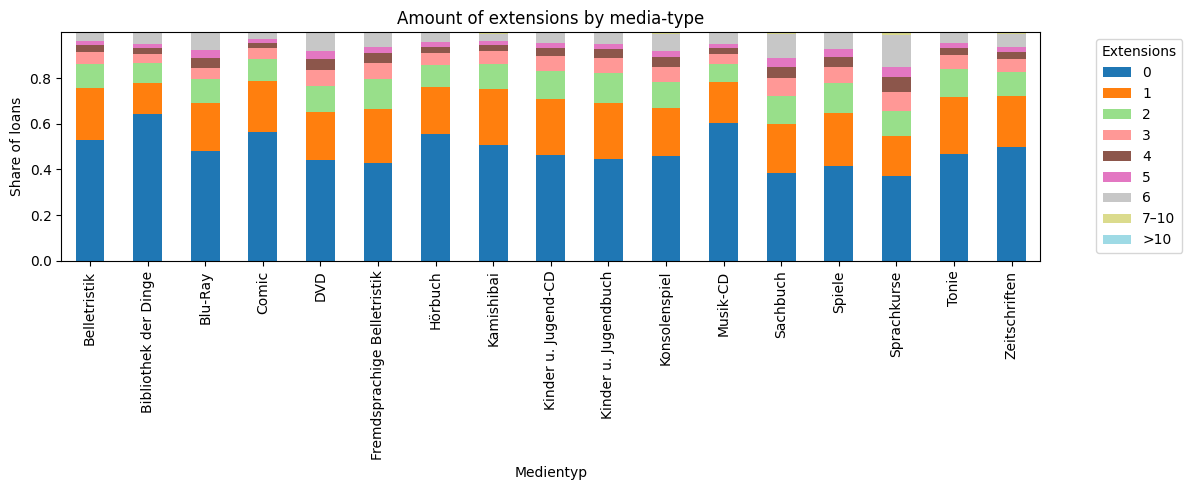

In [10]:
extension_data_frame = all_data_frame.copy()

# create the bins (cutoff points)
bins   = [-0.1, 0, 1, 2, 3, 4, 5, 6, 10, float("inf")]
labels = ["0", "1", "2", "3", "4", "5", "6", "7–10", ">10"]

# add column for bins
extension_data_frame["extension_bin"] = pd.cut(
    extension_data_frame["Anzahl_Verlängerungen"],
    bins=bins,
    labels=labels,
    include_lowest=True,
)

# count media types per bin
distribution_per_media_type = (
    extension_data_frame
    .groupby(["Medientyp", "extension_bin"], observed=True)
    .size()
    .unstack(fill_value=0)
)

# share per media type
distribution_per_media_type = distribution_per_media_type.div(distribution_per_media_type.sum(axis=1), axis=0)

# bar chart
ax = distribution_per_media_type.plot(kind="bar", stacked=True, figsize=(12, 5), colormap="tab20")
plt.ylabel("Share of loans")
plt.title("Amount of extensions by media-type")
plt.legend(title="Extensions", bbox_to_anchor=(1.05, 1), loc="upper left")
plt.tight_layout()
plt.show()


The chart shows that most loans fall into the 1–6 extension bins. Some media types, such as “Sprachkurse,” stand out with comparatively high numbers of extensions. This is likely because language courses are often used over a longer period and require a lot of work and practice, which makes renewals more common.

The next step is to find correlations between extensions and late returns per media type. To get a first impression we look at a scatter plot with the late return rate per

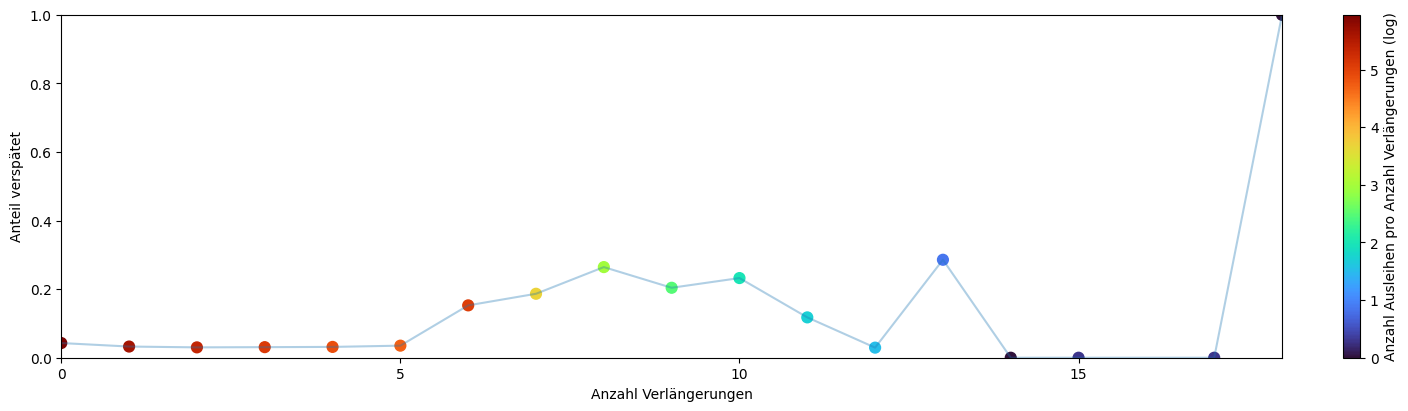

In [11]:
extension_data_frame["late"] = (extension_data_frame["Verspätet"] == "Ja").astype(int)

late_rate_by_extensions = (
    extension_data_frame.groupby("Anzahl_Verlängerungen")["late"]
    .agg(n="size", late_rate="mean")
    .reset_index()
    .sort_values("Anzahl_Verlängerungen")
)

x = late_rate_by_extensions["Anzahl_Verlängerungen"].to_numpy()
y = late_rate_by_extensions["late_rate"].to_numpy()
n = late_rate_by_extensions["n"].to_numpy()

fig, ax = plt.subplots(figsize=(14, 4), constrained_layout=True)

c = np.log10(n)

scatter = ax.scatter(x, y, c=c, s=60, cmap="turbo")
ax.plot(x, y, alpha=0.35)

ax.set_xlabel("Anzahl Verlängerungen")
ax.set_ylabel("Anteil verspätet")
ax.set_xlim(left=0, right=x.max())
ax.margins(x=0)
ax.set_ylim(0, 1)
ax.set_xticks(np.arange(0, x.max() + 1, 5))

color_bar = plt.colorbar(scatter, ax=ax)
color_bar.set_label("Anzahl Ausleihen pro Anzahl Verlängerungen (log)")

plt.show()

At first glance, the plot does not indicate a meaningful correlation. The fluctuations become larger as the number of borrowings decreases, and the tail with very few borrowings looks particularly unusual.

Most borrowings fall between 1 and 6 extensions, so we should examine this range in more detail

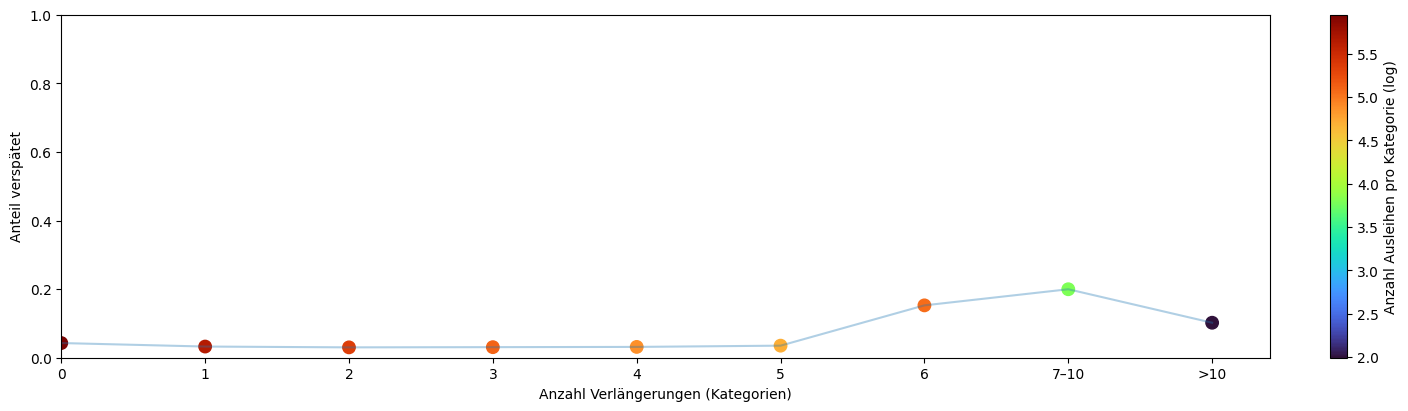

In [13]:
# look at smaller range (categories of extension from above)
categorized_extension_data = extension_data_frame.copy()

categorized_extension_data["extensions_bin"] = pd.cut(
    categorized_extension_data["Anzahl_Verlängerungen"],
    bins=bins,
    labels=labels,
    right=True,
    include_lowest=True
)

late_rate_by_category = (
    categorized_extension_data.groupby("extensions_bin", observed=True)["late"]
    .agg(n="size", late_rate="mean")
    .reindex(labels)
    .reset_index()
)

x_labels = late_rate_by_category["extensions_bin"].astype(str).to_numpy()
x = late_rate_by_extensions["Anzahl_Verlängerungen"].to_numpy()
y = late_rate_by_category["late_rate"].to_numpy()
n = late_rate_by_category["n"].to_numpy()

fig, ax = plt.subplots(figsize=(14, 4), constrained_layout=True)

c = np.log10(n)
scatter = ax.scatter(np.arange(len(x_labels)), y, c=c, s=80, cmap="turbo")
ax.plot(np.arange(len(x_labels)), y, alpha=0.35)

ax.set_xlabel("Anzahl Verlängerungen (Kategorien)")
ax.set_ylabel("Anteil verspätet")
ax.set_ylim(0, 1)
ax.set_xlim(left=0)
ax.set_xticks(np.arange(len(x_labels)))
ax.set_xticklabels(x_labels)

color_bar = plt.colorbar(scatter, ax=ax)
color_bar.set_label("Anzahl Ausleihen pro Kategorie (log)")

plt.show()

A closer look at the lower range of extension counts does not reveal any meaningful insights. The late-return rate appears constant, with only a small spike in segments where the number of observations is low.

But maybe there is a correlation when we look at the media types. To explore this, we use a scatter plot with the percentage of loans with extensions on the x-axis and the late-return rate on the y-axis. Bubble size is proportional to the number of loans for each media type.

In [14]:
per_media_type_data = per_media_type_table.copy()

def show_per_media_type_scatter_plot(input_data_frame):
    input_data_frame["size"] = 50 + 400 * np.sqrt(input_data_frame["n_loans"] / input_data_frame["n_loans"].max())
    figure = px.scatter(
        input_data_frame,
        x="pct_with_extension",
        y="late_rate",
        size="size",
        hover_name="Medientyp",
        hover_data={
            "n_loans": True,
            "pct_with_extension": ":.2f",
            "late_rate": ":.2f",
            "size": False
        },
        labels={
            "pct_with_extension": "Percent with extension",
            "late_rate": "Late rate",
            "n_loans": "amount fo loans"
        },
        title="Extensions vs Late returns",
        trendline="ols"
    )

    figure.update_traces(marker=dict(opacity=0.75))
    figure.update_layout(
        xaxis_title="Percentage with extension (%)",
        yaxis_title="Late rate (%)",
        width=600,
        height=600,
    )

    figure.show()

show_per_media_type_scatter_plot(per_media_type_data)


This looks quite interesting. “Bibliothek der Dinge” stands out as a strong outlier, while the remaining media types appear to follow a fairly linear pattern. In the next step, we exclude “Bibliothek der Dinge” and revisit the plot. We also compute the Pearson correlation coefficient.

In [15]:
table_without_bdd = per_media_type_table[per_media_type_table["Medientyp"] != "Bibliothek der Dinge"].copy()

x = table_without_bdd["pct_with_extension"].to_numpy()
y = table_without_bdd["late_rate"].to_numpy()

pearson_coefficient = np.corrcoef(x, y)[0, 1]

print(f"Pearson r: {pearson_coefficient:.3f}")
show_per_media_type_scatter_plot(table_without_bdd)

Pearson r: 0.773


So we can see a linear relationship across media types. Media types with higher percentage of loans that get extended tend to have a higher late-return rate.

But does the amount of extensions matter for the relationship?


In [16]:
extensions_without_bdd = extension_data_frame[extension_data_frame["Medientyp"] != "Bibliothek der Dinge"].copy()
extensions_without_bdd["late"] = (extensions_without_bdd["Verspätet"] == "Ja").astype(int)

ks = [1, 2, 3, 4, 5, 6, 10]

per_media = extensions_without_bdd.groupby("Medientyp").agg(
    n_loans=("issue_id", "size"),
    late_rate=("late", "mean"),
).reset_index()

for k in ks:
    per_media[f"pct_ext_ge_{k}"] = (
        extensions_without_bdd.assign(flag=extensions_without_bdd["Anzahl_Verlängerungen"] >= k)
        .groupby("Medientyp")["flag"].mean()
        .values
    )

# in %
per_media["late_rate"] *= 100
for k in ks:
    per_media[f"pct_ext_ge_{k}"] *= 100

# correlations
for k in ks:
    x = per_media[f"pct_ext_ge_{k}"].to_numpy()
    y = per_media["late_rate"].to_numpy()
    pear = np.corrcoef(x, y)[0, 1]
    spear = pd.Series(x).corr(pd.Series(y), method="spearman")
    print(f">={k}: Pearson r={pear:.3f} | Spearman ρ={spear:.3f}")


# look at extended only, remove outliers
df_ext = extensions_without_bdd[
    (extensions_without_bdd["Anzahl_Verlängerungen"] >= 1) &
    (extensions_without_bdd["Anzahl_Verlängerungen"] <= 10)
    ].copy()


mean_median_ext = (
    df_ext.groupby("Medientyp")["Anzahl_Verlängerungen"]
    .agg(mean_extensions="mean", median_extensions="median", n_extenders="size")
    .reset_index()
    .sort_values("n_extenders", ascending=False)
)

plot_df = (
    per_media[["Medientyp", "late_rate", "n_loans"]]
    .merge(mean_median_ext[["Medientyp", "mean_extensions", "n_extenders"]], on="Medientyp", how="left")
)

fig = px.scatter(
    plot_df,
    x="mean_extensions",
    y="late_rate",
    size="n_loans",
    size_max=40,
    hover_name="Medientyp",
    hover_data={
        "n_loans": True,
        "n_extenders": True,
        "mean_extensions": ":.2f",
        "late_rate": ":.2f",
    },
    labels={
        "mean_extensions": "Mean # extensions (only extended loans, <=10)",
        "late_rate": "Late rate (%)",
        "n_loans": "Loans (n)",
        "n_extenders": "Extended loans (n)"
    },
    title="Late rate vs mean extensions (per media type)",
    trendline="ols"
)

fig.update_layout(width=600, height=600)
fig.show()

x = plot_df["mean_extensions"].to_numpy()
y = plot_df["late_rate"].to_numpy()

mask = np.isfinite(x) & np.isfinite(y)   # drop NaN/inf
pearson_r = np.corrcoef(x[mask], y[mask])[0, 1]

print(f"Pearson r (mean_extensions vs late_rate): {pearson_r:.3f}")


>=1: Pearson r=0.773 | Spearman ρ=0.653
>=2: Pearson r=0.780 | Spearman ρ=0.741
>=3: Pearson r=0.758 | Spearman ρ=0.659
>=4: Pearson r=0.741 | Spearman ρ=0.682
>=5: Pearson r=0.722 | Spearman ρ=0.647
>=6: Pearson r=0.707 | Spearman ρ=0.668
>=10: Pearson r=0.089 | Spearman ρ=-0.139


Pearson r (mean_extensions vs late_rate): 0.664


## Analysis of days to late and late returns
Another interesting property of a borrowing is the amount of days it is returned late. Is there a correlation to late returns?

First we look at a basic table of properties regarding the amount of days an object was returned late.

### Column descriptions (days-late summary by media type)
- **mean_days_late_if_late**
  Average number of days late, conditional on the loan being late.
- **median_days_late_if_late**
  Median number of days late, conditional on the loan being late.
- **p75_days_late**
  75th percentile of days late **among late loans only**
- **p90_days_late**
  90th percentile of days late **among late loans only**
- **mean_days_late_per_loan_duration (%)**
  Average ratio of days late to total loan duration, expressing lateness relative to how long items were borrowed.

In [17]:
def p75_if_late(series):
    numeric_series = pd.to_numeric(series, errors="coerce")
    numeric_series = numeric_series[numeric_series > 0]
    return np.percentile(numeric_series, 75) if len(numeric_series) > 0 else 0.0

def p90_if_late(series):
    numeric_series = pd.to_numeric(series, errors="coerce")
    numeric_series = numeric_series[numeric_series > 0]
    return np.percentile(numeric_series, 90) if len(numeric_series) > 0 else 0.0


days_late_table = (
    all_data_frame
    .assign(
        late=lambda df: df["Verspätet"] == "Ja",
        days_late=lambda df: df["Tage_zu_spät"].clip(lower=0),
        days_late_per_loan_duration=lambda df: df["Tage_zu_spät"].clip(lower=0) / df["Leihdauer"]
    )
    .groupby("Medientyp")
    .agg(
        n_loans=("Leihdauer", "size"),

        late_rate=("late", "mean"),

        # basic properties
        mean=("days_late", "mean"),
        median=("days_late", "median"),
        max_days_late=("days_late", "max"),

        # if late
        mean_days_late_if_late=("days_late", lambda x: x[x > 0].mean()),
        median_days_late_if_late=("days_late", lambda x: x[x > 0].median()),
        p75_days_late=("Tage_zu_spät", p75_if_late),
        p90_days_late=("Tage_zu_spät", p90_if_late),

        # relative lateness
        mean_days_late_per_loan_duration=("days_late_per_loan_duration", "mean")

    )
    .reset_index()
    .assign(
        late_rate=lambda df: (df["late_rate"] * 100).round(2),
        mean_days_late_per_loan_duration=lambda df: (df["mean_days_late_per_loan_duration"] * 100).round(2),
    )
    .sort_values("late_rate", ascending=False)
)

display(days_late_table)


,Medientyp,n_loans,late_rate,mean,median,max_days_late,mean_days_late_if_late,median_days_late_if_late,p75_days_late,p90_days_late,mean_days_late_per_loan_duration
1,Bibliothek der Dinge,1104,11.96,0.752717,0.0,62.0,6.295455,3.0,8.00,13.9,2.43
14,Sprachkurse,6501,7.91,0.883095,0.0,151.0,11.169261,5.0,13.75,26.0,0.90
10,Konsolenspiel,7115,7.01,0.926212,0.0,173.0,13.206413,6.0,14.00,32.2,1.14
2,Blu-Ray,2901,6.20,0.465357,0.0,40.0,7.500000,5.0,10.00,21.0,1.25
7,Kamishibai,1565,6.13,0.555272,0.0,48.0,9.052083,5.0,14.00,22.0,0.97
4,DVD,245197,5.88,0.430723,0.0,251.0,7.322471,4.0,8.00,15.0,0.95
13,Spiele,18057,5.65,0.549095,0.0,232.0,9.711068,5.0,12.00,22.0,0.72
12,Sachbuch,321920,5.62,0.516684,0.0,326.0,9.201250,5.0,10.00,20.0,0.60
15,Tonie,18448,5.00,0.355811,0.0,145.0,7.119306,4.0,9.00,16.9,0.58
5,Fremdsprachige Belletristik,24212,4.80,0.508136,0.0,224.0,10.587780,5.0,11.00,24.0,0.61


In [18]:
def p75_if_late(series):
    numeric_series = pd.to_numeric(series, errors="coerce")
    numeric_series = numeric_series[numeric_series > 0]
    return np.percentile(numeric_series, 75) if len(numeric_series) > 0 else 0.0

def p90_if_late(series):
    numeric_series = pd.to_numeric(series, errors="coerce")
    numeric_series = numeric_series[numeric_series > 0]
    return np.percentile(numeric_series, 90) if len(numeric_series) > 0 else 0.0


days_late_table = (
    all_data_frame
    .assign(
        late=lambda df: df["Verspätet"] == "Ja",
        days_late=lambda df: df["Tage_zu_spät"].clip(lower=0),
        days_late_per_loan_duration=lambda df: df["Tage_zu_spät"].clip(lower=0) / df["Leihdauer"]
    )
    .groupby("Medientyp")
    .agg(
        n_loans=("Leihdauer", "size"),

        late_rate=("late", "mean"),

        # basic properties
        mean=("days_late", "mean"),
        median=("days_late", "median"),
        max_days_late=("days_late", "max"),

        # if late
        mean_days_late_if_late=("days_late", lambda x: x[x > 0].mean()),
        median_days_late_if_late=("days_late", lambda x: x[x > 0].median()),
        p75_days_late=("Tage_zu_spät", p75_if_late),
        p90_days_late=("Tage_zu_spät", p90_if_late),

        # relative lateness
        mean_days_late_per_loan_duration=("days_late_per_loan_duration", "mean")

    )
    .reset_index()
    .assign(
        late_rate=lambda df: (df["late_rate"] * 100).round(2),
        mean_days_late_per_loan_duration=lambda df: (df["mean_days_late_per_loan_duration"] * 100).round(2),
    )
    .sort_values("late_rate", ascending=False)
)

display(days_late_table)


,Medientyp,n_loans,late_rate,mean,median,max_days_late,mean_days_late_if_late,median_days_late_if_late,p75_days_late,p90_days_late,mean_days_late_per_loan_duration
1,Bibliothek der Dinge,1104,11.96,0.752717,0.0,62.0,6.295455,3.0,8.00,13.9,2.43
14,Sprachkurse,6501,7.91,0.883095,0.0,151.0,11.169261,5.0,13.75,26.0,0.90
10,Konsolenspiel,7115,7.01,0.926212,0.0,173.0,13.206413,6.0,14.00,32.2,1.14
2,Blu-Ray,2901,6.20,0.465357,0.0,40.0,7.500000,5.0,10.00,21.0,1.25
7,Kamishibai,1565,6.13,0.555272,0.0,48.0,9.052083,5.0,14.00,22.0,0.97
4,DVD,245197,5.88,0.430723,0.0,251.0,7.322471,4.0,8.00,15.0,0.95
13,Spiele,18057,5.65,0.549095,0.0,232.0,9.711068,5.0,12.00,22.0,0.72
12,Sachbuch,321920,5.62,0.516684,0.0,326.0,9.201250,5.0,10.00,20.0,0.60
15,Tonie,18448,5.00,0.355811,0.0,145.0,7.119306,4.0,9.00,16.9,0.58
5,Fremdsprachige Belletristik,24212,4.80,0.508136,0.0,224.0,10.587780,5.0,11.00,24.0,0.61
